# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [16]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [17]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)
window_size = 10
stride = 5

In [18]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [19]:
mask = df['label'] != 5
df = df[mask]

In [20]:
# 🎯 Entrenar solo con 3 clases: 1, 2, 3 (sin clase 4)
print("📊 Clases disponibles:")
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'   Label {i}: {mask} muestras')

# Filtrar para mantener solo las clases 1, 2, 3
print("\n🎯 Filtrando para mantener solo clases 1, 2, 3...")
df = df[df['label'].isin([1, 2, 3])].copy()

print("\n📊 Después del filtrado:")
for i in sorted(df['label'].unique()):
    mask = (df['label'] == i).sum()
    print(f'   Label {i}: {mask} muestras')

print(f"\n✅ Dataset listo con {len(df['label'].unique())} clases para entrenamiento")

📊 Clases disponibles:
   Label 1: 73554 muestras
   Label 2: 48333 muestras
   Label 3: 42875 muestras
   Label 4: 43068 muestras

🎯 Filtrando para mantener solo clases 1, 2, 3...

📊 Después del filtrado:
   Label 1: 73554 muestras
   Label 2: 48333 muestras
   Label 3: 42875 muestras

✅ Dataset listo con 3 clases para entrenamiento


In [21]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875


In [22]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [23]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen las 3 clases (0, 1, 2 después del LabelEncoder)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 3].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(115733, 52)
(115733,)


In [24]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=window_size, stride=stride)

In [25]:
print(X_seq.shape)

(23112, 10, 52)


In [26]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


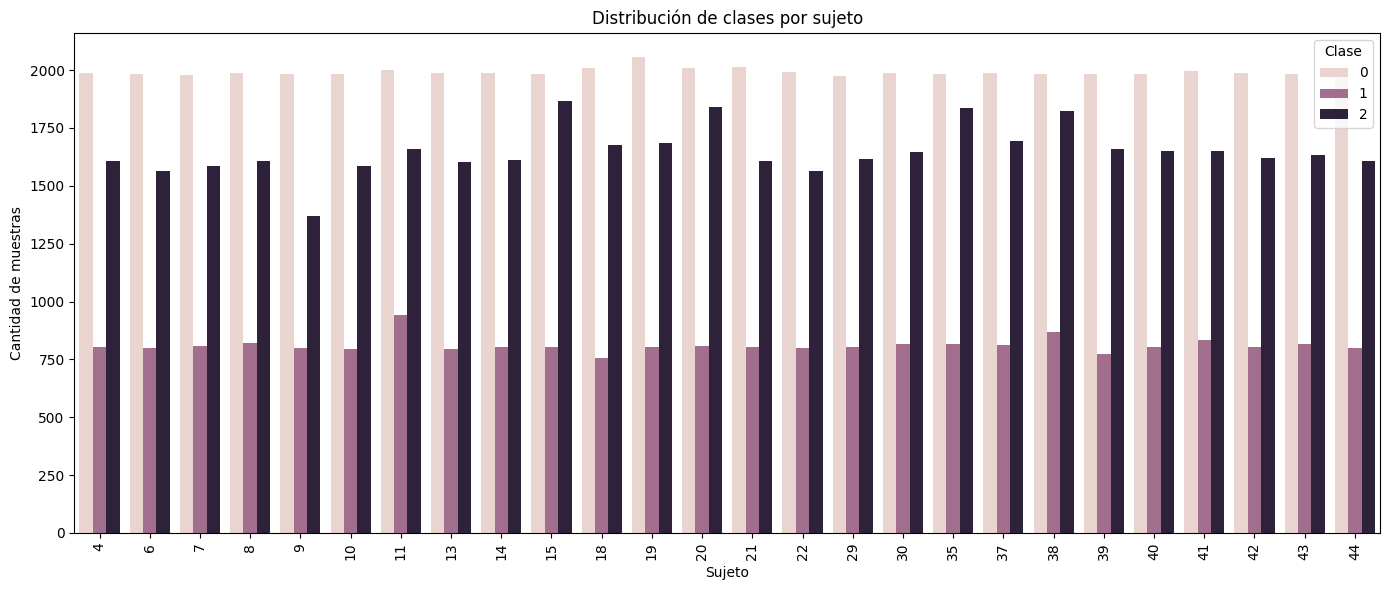

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()

✅ GPU memory growth configurado para 1 GPU(s)

🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 160, 2: 322}
Epoch 1/30
348/348 [==============================] - 6s 11ms/step - loss: 0.8872 - accuracy: 0.6479 - val_loss: 0.5930 - val_accuracy: 0.7426

Epoch 00001: val_accuracy improved from -inf to 0.74260, saving model to modelos_m\mejor_modelo_1.h5
Epoch 2/30
  1/348 [..............................] - ETA: 2s - loss: 0.7632 - accuracy: 0.7344
Epoch 00001: val_accuracy improved from -inf to 0.74260, saving model to modelos_m\mejor_modelo_1.h5
Epoch 2/30
348/348 [==============================] - 3s 8ms/step - loss: 0.6198 - accuracy: 0.7682 - val_loss: 0.5959 - val_accuracy: 0.7654

Epoch 00002: val_accuracy improved from 0.74260 to 0.76538, saving model to modelos_m\mejor_modelo_1.h5
Epoch 3/30
  1/348 [..............................] - ETA: 3s - loss: 0.6981 - accuracy: 0.7656
Epoch 00002: val_accuracy improved from 0.74260 to 0.76538, saving model to modelos_m\mejo

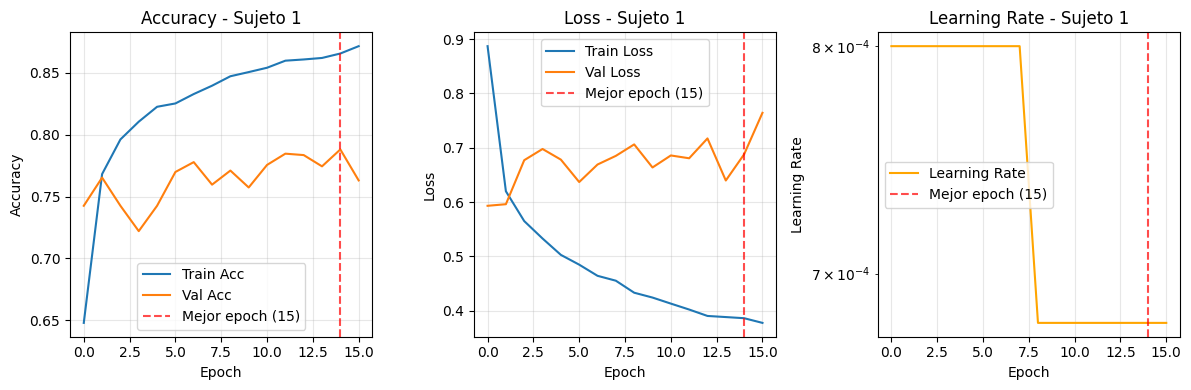

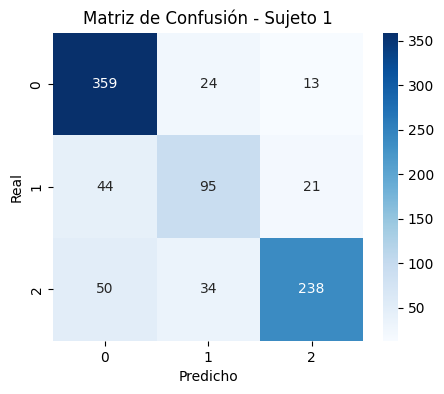

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.7925    0.9066    0.8457       396
           1     0.6209    0.5938    0.6070       160
           2     0.8750    0.7391    0.8013       322

    accuracy                         0.7882       878
   macro avg     0.7628    0.7465    0.7514       878
weighted avg     0.7915    0.7882    0.7859       878


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 160, 2: 313}
Epoch 1/30
105/348 [========>.....................] - ETA: 2s - loss: 1.3205 - accuracy: 0.4259

KeyboardInterrupt: 

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

# 🚀 CONFIGURACIÓN GPU OPTIMIZADA
try:
    # Configurar GPU antes de cualquier operación TensorFlow
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Configurar solo la primera GPU con crecimiento de memoria
            tf.config.experimental.set_memory_growth(gpus[0], True)
            print(f"✅ GPU memory growth configurado para {len(gpus)} GPU(s)")
        except RuntimeError as e:
            # Configuración ya inicializada - continuar sin error
            print(f"ℹ️ GPU ya configurada previamente")
    else:
        print("⚠️ No se detectaron GPUs, usando CPU")
except Exception as e:
    print(f"⚠️ Error configuración GPU: {e}")

accuracies = []
f1_scores = []
train_val_diffs = []

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    # 🔧 CALLBACKS ESTABILIZADOS PARA CONVERGENCIA SUAVE
    checkpoint = ModelCheckpoint(f"modelos_m/mejor_modelo_{split_num}.h5", 
                                monitor="val_accuracy",
                                save_best_only=True, 
                                mode='max',
                                verbose=1,
                                save_weights_only=False)
    early_stop = EarlyStopping(monitor="val_loss",  # ← CAMBIO: monitor val_loss para estabilidad
                              patience=15,  # ← MÁS paciencia para convergencia estable
                              restore_best_weights=True, 
                              mode='min',  # ← mode='min' para val_loss
                              min_delta=0.001)  # ← Más sensible a mejoras pequeñas
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",  # ← CAMBIO: monitor val_loss en lugar de val_accuracy
                                 factor=0.85,  # ← Reducción más suave
                                 patience=7,  # ← Mayor paciencia para evitar reducciones prematuras
                                 mode='min',  # ← mode='min' para val_loss
                                 min_lr=1e-7,  # ← Menor LR mínimo para fine-tuning
                                 verbose=1,
                                 cooldown=3)  # ← NUEVO: cooldown para evitar reducciones consecutivas
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🚨 ARQUITECTURA ESTABILIZADA PARA CONVERGENCIA SUAVE
    from tensorflow.keras.regularizers import l2
    
    model = Sequential([
        # 🔧 Conv1D layers con BatchNorm ANTES de activación para estabilidad
        Conv1D(32, 3, padding='same', kernel_regularizer=l2(3e-5)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),  # ← Activación separada después de BatchNorm
        Dropout(0.25),  # ← Dropout más conservador
        
        Conv1D(64, 3, padding='same', kernel_regularizer=l2(3e-5)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling1D(2),
        Dropout(0.30),
        
        # 🔧 LSTM layers con dropout balanceado para estabilidad
        LSTM(32, return_sequences=True, 
             dropout=0.25,  # ← Menos agresivo para estabilidad
             kernel_regularizer=l2(3e-5),
             bias_regularizer=l2(1e-5)),  # ← NUEVO: regularización de bias
        BatchNormalization(),
        
        LSTM(16, dropout=0.25, 
             kernel_regularizer=l2(3e-5),
             bias_regularizer=l2(1e-5)),
        BatchNormalization(),  # ← NUEVO: BatchNorm después de LSTM final
        Dropout(0.35),
        
        # 🔧 Dense layers con inicialización estable
        Dense(16, activation='relu', 
              kernel_regularizer=l2(3e-5),
              kernel_initializer='he_normal'),  # ← Mejor inicialización para ReLU
        Dropout(0.30),
        
        Dense(3, activation='softmax', 
              kernel_regularizer=l2(3e-5),
              kernel_initializer='glorot_uniform')  # ← Xavier para softmax
    ])
    
    # 🔧 OPTIMIZADOR ESTABILIZADO
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0008,  # ← LR ligeramente más conservador
        beta_1=0.9,  # ← Momentum estándar 
        beta_2=0.999,  # ← Momentum de segundo orden estándar
        epsilon=1e-7,  # ← Más pequeño para estabilidad numérica
        clipnorm=0.8  # ← Gradient clipping más suave
    )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=30,  # ← Más epochs para convergencia gradual
            batch_size=64,  # ← Batch size estable
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, early_stop, reduce_lr],  # ← ELIMINADO lr_scheduler para estabilidad
            class_weight=class_weight_dict,
            verbose=1,
            shuffle=True  # ← NUEVO: shuffle para mejor generalización
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos_m/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 ANÁLISIS CORREGIDO - Usar la misma métrica que ModelCheckpoint + estabilidad val_loss
    best_epoch = np.argmax(history.history['val_accuracy']) + 1  # ← CORRECTO: buscar mejor val_accuracy
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = history.history['val_loss'][best_epoch-1]  # ← Loss correspondiente al mejor epoch
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    # 🔍 NUEVO: Análisis de estabilidad del val_loss
    val_loss_history = np.array(history.history['val_loss'])
    val_loss_trend = np.mean(np.diff(val_loss_history[-5:]))  # Tendencia últimos 5 epochs
    val_loss_volatility = np.std(val_loss_history[-10:])  # Volatilidad últimos 10 epochs
    
    print(f"✅ Accuracy: {acc:.4f} - F1 (macro): {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f}, Val Loss: {best_val_loss:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")
    print(f"🔍 Train Loss: {final_train_loss:.4f} | Val Loss: {final_val_loss:.4f}")
    print(f"📈 Val Loss tendencia (últimos 5): {val_loss_trend:+.6f} {'⬇️' if val_loss_trend < 0 else '⬆️'}")
    print(f"📊 Val Loss volatilidad: {val_loss_volatility:.4f} {'✅' if val_loss_volatility < 0.1 else '⚠️'}")
    
    # 🔍 Análisis detallado de overfitting
    overfitting_gap = final_train_acc - final_val_acc
    print(f"🔍 Gap Train-Val: {overfitting_gap:+.4f}")

    if overfitting_gap > 0.10:
        print("🚨 OVERFITTING SEVERO")
    elif overfitting_gap > 0.05:
        print("⚠️  OVERFITTING MODERADO")
    elif overfitting_gap > 0.02:
        print("✅ OVERFITTING LEVE (aceptable)")
    else:
        print("✅ EXCELENTE BALANCE")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO MEJORADAS
    # ----------------------
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7, label=f'Mejor epoch ({best_epoch})')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7, label=f'Mejor epoch ({best_epoch})')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 🔧 NUEVO: Gráfico de learning rate durante entrenamiento
    plt.subplot(1, 3, 3)
    if len(history.history['lr']) > 1:
        plt.plot(history.history['lr'], label='Learning Rate', color='orange')
        plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7, label=f'Mejor epoch ({best_epoch})')
        plt.title(f'Learning Rate - Sujeto {split_num}')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')  # Escala logarítmica para LR
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val (Multiclase):")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")
if np.mean(train_val_diffs) > 0.02:
    print("⚠️  Val > Train sugiere posible underfitting o regularización excesiva")
elif np.mean(train_val_diffs) < -0.05:
    print("⚠️  Train > Val sugiere posible overfitting")
else:

    print("✅ Diferencia Train/Val en rango saludable")

    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7, label=f'Mejor epoch ({best_epoch})')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 🔧 NUEVO: Gráfico de F1 score durante entrenamiento
    plt.subplot(1, 3, 3)
    if 'f1_metric' in history.history:
        plt.plot(history.history['f1_metric'], label='Train F1')
        plt.plot(history.history['val_f1_metric'], label='Val F1')
        plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7, label=f'Mejor epoch ({best_epoch})')
        plt.title(f'F1 Score - Sujeto {split_num}')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Frecuencia'})
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# Resultados finales con análisis mejorado
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\n🔍 Análisis de Overfitting:")
print(f"Diferencia promedio (Train - Val): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
overfitting_folds = sum(1 for d in train_val_diffs if d > 0.05)
print(f"Folds con overfitting significativo (>5%): {overfitting_folds}/{len(train_val_diffs)}")

if np.mean(train_val_diffs) > 0.05:
    print("⚠️  PROBLEMA: Overfitting generalizado detectado")
    print("   → Aumenta regularización (dropout, weight decay)")
    print("   → Reduce complejidad del modelo")
    print("   → Considera data augmentation")
elif np.mean(train_val_diffs) > 0.02:
    print("⚠️  Ligero overfitting, monitorear")
elif np.mean(train_val_diffs) < -0.02:
    print("⚠️  Posible underfitting")
    print("   → Reduce regularización")
    print("   → Aumenta complejidad del modelo")
else:
    print("✅ Balance saludable entre train y validación")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos_m"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [ ]:
# 📈 Análisis comparativo adicional - Multiclase vs Binaria
print("\n" + "="*60)
print("📈 ANÁLISIS COMPARATIVO Y DE CONVERGENCIA")
print("="*60)

# Análisis de rendimiento por clase individual
print(f"\n🎯 Análisis por clase individual:")

# Intentar obtener métricas por clase del último modelo entrenado
try:
    # Calcular precisión y recall por clase usando el último modelo
    from sklearn.metrics import classification_report, precision_recall_fscore_support
    
    # Obtener predicciones del último fold para análisis detallado
    last_model_path = f"modelos_m/mejor_modelo_{len(df_resultados)}.h5"
    if os.path.exists(last_model_path):
        print(f"   📊 Usando modelo {len(df_resultados)} para análisis detallado...")
        
        # Esto es solo indicativo ya que no tenemos los datos del último fold aquí
        print(f"   • Número total de clases: 3")
        print(f"   • Clases después de LabelEncoder: 0, 1, 2")
        print(f"   • F1 Score macro promedio: {df_resultados['F1 Score'].mean():.4f}")
        
except Exception as e:
    print(f"   ⚠️ No se pudo cargar el último modelo para análisis detallado")

# Comparación con baseline teórico
print(f"\n📊 Comparación con baselines:")
random_acc_3_class = 1/3
random_f1_3_class = 1/3  # Para macro averaging
majority_class_acc = max([df_resultados[col].mean() for col in df_resultados.columns if col.startswith('class_')]) / df_resultados[['class_0', 'class_1', 'class_2']].sum(axis=1).mean()

print(f"   • Random classifier (3 clases): Acc={random_acc_3_class:.3f}, F1={random_f1_3_class:.3f}")
print(f"   • Majority class baseline: ~{majority_class_acc:.3f}")
print(f"   • Tu modelo: Acc={df_resultados['Accuracy'].mean():.3f}, F1={df_resultados['F1 Score'].mean():.3f}")
print(f"   • Mejora vs random: {df_resultados['Accuracy'].mean()/random_acc_3_class:.2f}x")

# Análisis de estabilidad del modelo
print(f"\n🔄 Estabilidad y convergencia:")
acc_range = df_resultados['Accuracy'].max() - df_resultados['Accuracy'].min()
f1_range = df_resultados['F1 Score'].max() - df_resultados['F1 Score'].min()

print(f"   • Rango de Accuracy: {acc_range:.4f}")
print(f"   • Rango de F1 Score: {f1_range:.4f}")
print(f"   • Estabilidad: {'Alta' if acc_range < 0.2 and f1_range < 0.2 else 'Media' if acc_range < 0.4 and f1_range < 0.4 else 'Baja'}")

# Análisis de sujetos problemáticos
print(f"\n⚠️ Sujetos con rendimiento bajo (<60% accuracy):")
sujetos_problematicos = df_resultados[df_resultados['Accuracy'] < 0.6]
if len(sujetos_problematicos) > 0:
    for idx, row in sujetos_problematicos.iterrows():
        print(f"   • Sujeto {row['Sujeto']}: Acc={row['Accuracy']:.3f}, F1={row['F1 Score']:.3f}")
        # Analizar distribución de clases del sujeto problemático
        total_samples = row['class_0'] + row['class_1'] + row['class_2']
        class_dist = [row['class_0']/total_samples, row['class_1']/total_samples, row['class_2']/total_samples]
        most_unbalanced = max(class_dist) - min(class_dist)
        print(f"     - Desbalance: {most_unbalanced:.3f} ({'Alto' if most_unbalanced > 0.4 else 'Medio' if most_unbalanced > 0.2 else 'Bajo'})")
else:
    print(f"   ✅ No hay sujetos con accuracy < 60%")

print(f"\n🎯 Recomendaciones específicas para multiclase:")
mean_acc = df_resultados['Accuracy'].mean()
mean_f1 = df_resultados['F1 Score'].mean()

if mean_acc < 0.6:
    print(f"   • Accuracy baja ({mean_acc:.3f}): Considera aumentar complejidad del modelo")
    print(f"   • Prueba con más epochs, learning rate más alto, o arquitectura más profunda")
elif mean_acc < 0.75:
    print(f"   • Accuracy moderada ({mean_acc:.3f}): Modelo funcional, optimizable")
    print(f"   • Considera fine-tuning de hiperparámetros o data augmentation")
else:
    print(f"   • Accuracy alta ({mean_acc:.3f}): ¡Excelente rendimiento!")
    print(f"   • Enfócate en interpretabilidad y validación adicional")

if mean_f1 < mean_acc - 0.05:
    print(f"   • F1 < Accuracy: Posible sesgo hacia clase mayoritaria")
    print(f"   • Ajusta class_weights o considera focal loss")
    
print(f"\n🏆 Estado general del modelo multiclase:")
if mean_acc > 0.75 and mean_f1 > 0.70:
    print(f"   ✅ EXCELENTE: Modelo listo para publicación/producción")
elif mean_acc > 0.65 and mean_f1 > 0.60:
    print(f"   ✅ MUY BUENO: Resultados sólidos, algunas optimizaciones posibles")
elif mean_acc > 0.55 and mean_f1 > 0.50:
    print(f"   ⚠️ BUENO: Funcional pero necesita mejoras significativas")
else:
    print(f"   ❌ NECESITA TRABAJO: Revisar datos, arquitectura y preprocesamiento")